In [3]:
# !pip install -qr "../requirements.txt"
# !pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 6.0 MB/s eta 0:00:0000:0100:01


In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

# Load data

## Load data - Demonstration

In [2]:
df = pd.read_csv('../data/drive-me-not/trace1.csv')
# benign_flight.info()

#filter out the anchor points
df = df[df['Anchor_Number'] == 0]
df

,GPS_lat,GPS_long,Network_lat,Network_long,Time,Anchor_Number,Type,Registered,CID,LAC,MCC,MNC,dBm,level
0,25.328347,51.425060,0.0,0.0,1561278474631,0,GSM,True,23733,9301,427,1,-45,4
14,25.328347,51.425060,0.0,0.0,1561278474768,0,GSM,True,23733,9301,427,1,-45,4
28,25.328347,51.425060,0.0,0.0,1561278474932,0,GSM,True,23733,9301,427,1,-45,4
42,25.328347,51.425060,0.0,0.0,1561278475082,0,GSM,True,23733,9301,427,1,-45,4
56,25.328347,51.425060,0.0,0.0,1561278475263,0,GSM,True,23733,9301,427,1,-45,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34038,25.331563,51.421738,0.0,0.0,1561280145472,0,GSM,True,24882,9301,427,1,-57,4
34050,25.331563,51.421738,0.0,0.0,1561280155660,0,GSM,True,14792,150,427,2,-37,4
34057,25.331563,51.421738,0.0,0.0,1561280155829,0,GSM,True,24882,9301,427,1,-53,4
34070,25.331563,51.421738,0.0,0.0,1561280156156,0,GSM,True,24882,9301,427,1,-53,4


In [3]:
import pandasql as ps

# Filter out the rows whose change of position is not reflected in the coordinates
stmt = """SELECT * 
FROM df
WHERE Time in (
    SELECT min(Time) 
    FROM df
    GROUP BY GPS_lat, GPS_long 
    )
"""

df = ps.sqldf(stmt, locals())

In [4]:
from utils.haversine import haversine_component_distance

haversine_dist_lat, haversine_dist_lon = [], []

for rows in range(1, len(df)):
    dist =  haversine_component_distance(
        (df.loc[rows-1, 'GPS_lat'], df.loc[rows-1, 'GPS_long']), 
        (df.loc[rows, 'GPS_lat'], df.loc[rows, 'GPS_long'])
        )
    haversine_dist_lat.append(dist[0])
    haversine_dist_lon.append(dist[1])
    
pd.Series(haversine_dist_lat) / df.Time.diff().dropna().reset_index(drop=True)
pd.Series(haversine_dist_lon) / df.Time.diff().dropna().reset_index(drop=True)

0      0.000072
1      0.000057
2      0.000052
3      0.000081
4      0.000084
         ...   
527    0.000358
528    0.000111
529    0.001318
530    0.000291
531    0.000167
Length: 532, dtype: float64

In [5]:
df['vx'] = pd.Series(haversine_dist_lat) / df.Time.diff().dropna().reset_index(drop=True)
df['vy'] = pd.Series(haversine_dist_lon) / df.Time.diff().dropna().reset_index(drop=True)
df.dropna(inplace=True)

# compute acceleration
df['ax'] = df.vx.diff() / df.Time.diff()
df['ay'] = df.vy.diff() / df.Time.diff()
df.dropna(inplace=True)

selected_attributes = ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay']
df = df[selected_attributes]
df.to_csv('../data/drive-me-not/trace1_preprocessed_showcase.csv', index=False)

In [6]:
from utils.preprocessing import zero_one_normalization

# compute velocity
df['vx'] = df.GPS_long.diff() / df.Time.diff()
df['vy'] = df.GPS_lat.diff() / df.Time.diff()
df.dropna(inplace=True)

# compute acceleration
df['ax'] = df.vx.diff() / df.Time.diff()
df['ay'] = df.vy.diff() / df.Time.diff()
df.dropna(inplace=True)

# 0-1 normalization

for col in ['vx', 'vy', 'ax', 'ay']:
    df[col] = zero_one_normalization(df[col])

selected_attributes = ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay']
df = df[selected_attributes]
df.to_csv('../data/drive-me-not/trace1_preprocessed_showcase.csv', index=False)

In [7]:
from utils.visualization import plot_trace

plot_trace(df, mode="velocity", x_range=(51.34, 51.45), y_range=(25.28,25.35))

## Pipelining the dataloader

In [8]:
from utils.preprocessing import data_preprocessing

traces = ['../data/drive-me-not/trace'+ str(i) + '.csv' for i in range(1, 9)]

traces_df = [data_preprocessing(trace, trace_num=i+1, method="haversine") for i, trace in enumerate(traces)]

for df in traces_df:
    print(df.shape)

(531, 7)
(564, 7)
(316, 7)
(463, 7)
(297, 7)
(393, 7)
(396, 7)
(318, 7)


## Malicious Data

In [9]:
# trace 4 spoofed
from utils.preprocessing import data_preprocessing

# spoofed = pd.read_csv('../data/drive-me-not/trace4_spoofed.csv').drop(columns=['Unnamed: 0']).head()  


# estimated_trace4, trace4_spoofed 
# spoofed_4 = data_preprocessing('../data/drive-me-not/processed/trace4_spoofed.csv', 
#                              selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
#                              trace_num=4)

TRACE = 1

spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(TRACE)+'.csv', 
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                             trace_num=TRACE)
benign_data = data_preprocessing('../data/drive-me-not/trace'+str(TRACE)+'.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=TRACE)
benign_data['spoofed'] = 0


from utils.visualization import plot_trace

x_range_s, y_range_s = (spoofed_data.GPS_lat.min(), 
         spoofed_data.GPS_lat.max()), \
        (spoofed_data.GPS_long.min(), 
         spoofed_data.GPS_long.max())
        
x_range_b, y_range_b = (benign_data.GPS_lat.min(), 
         benign_data.GPS_lat.max()), \
        (benign_data.GPS_long.min(), 
         benign_data.GPS_long.max())
        
x_range, y_range = (min(x_range_s[0], x_range_b[0]), 
                   max(x_range_s[1], x_range_b[1])), \
                  (min(y_range_s[0], y_range_b[0]), 
                   max(y_range_s[1], y_range_b[1]))

plot_trace(spoofed_data.iloc[:, :], 
           mode="velocity", 
           colored=True, marker_size=2,
           x_range=y_range, 
           y_range=x_range,
           )

# plot_trace(benign_data.iloc[:, :], 
#            mode="velocity", 
#            colored=True, marker_size=2,
#            x_range=y_range, 
#            y_range=x_range,
#            )

In [10]:
benign_4 = data_preprocessing('../data/drive-me-not/trace4.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=4)
benign_4['spoofed'] = 0
plot_trace(benign_4.iloc[:, :], 
        #    mode="velocity", 
           colored=True, marker_size=2)

# plot trace

In [11]:
from utils.preprocessing import data_preprocessing

spoofed_list = [data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv', 
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                             trace_num=trace) for trace in range(1, 9)]
benign_list = [data_preprocessing('../data/drive-me-not/trace'+str(trace)+'.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=trace) for trace in range(1, 9)]
for benign in benign_list:  
    benign['spoofed'] = 0
    
from utils.visualization import plot_spoofed_and_benign

plot_spoofed_and_benign(spoofed_list, benign_list, marker_size=2)

benign_list[0]

,GPS_lat,GPS_long,Time,vx,vy,ax,ay,trace,spoofed
1,25.328332,51.425088,1561278477081,0.010072,0.004713,0.976035,0.959217,1,0
2,25.328313,51.425080,1561278477990,0.013238,0.004259,0.976119,0.959217,1,0
3,25.328287,51.425072,1561278478996,0.015429,0.006688,0.975942,0.959629,1,0
4,25.328255,51.425058,1561278480021,0.028643,0.006939,0.977400,0.959323,1,0
5,25.328198,51.425045,1561278481009,0.033991,0.009870,0.976382,0.959707,1,0
...,...,...,...,...,...,...,...,...,...
527,25.330870,51.420990,1561280127048,0.045363,0.029437,0.975410,0.959168,1,0
528,25.331425,51.421340,1561280133158,0.016199,0.009091,0.974996,0.958817,1,0
529,25.331608,51.421440,1561280138810,0.077685,0.108470,0.977126,0.961773,1,0
530,25.331632,51.421472,1561280138960,0.005971,0.023974,0.910602,0.879686,1,0


# PCA preprocessing

In [12]:
# union all the traces
df_processed_with_trace = pd.concat(traces_df)


trace_num = df_processed_with_trace['trace'].astype("int")

# # exclude trace 4 for testing
# df_processed_without_4 = df_processed_with_trace[df_processed_with_trace['trace'] != 4]
# df_processed = df_processed_without_4.drop(columns=['trace'])

# # Donot exclude trace 4 for testing
df_processed = df_processed_with_trace.drop(columns=['trace'])


# standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_processed)
df_processed = pd.DataFrame(scaler.transform(df_processed), columns=df_processed.columns)

trace_num.reset_index(drop=True, inplace=True)

# pca transformation
from utils.preprocessing import pca_transform

N_COMPONENTS = 3

df_train, pca_train = pca_transform(df_processed, n_components=N_COMPONENTS)
df_train['trace'] = trace_num
df_train

,pca-one,pca-two,pca-three,trace
0,0.960071,0.443752,0.732593,1
1,0.959436,0.444372,0.732361,1
2,0.958636,0.445725,0.731010,1
3,0.955913,0.449111,0.729489,1
4,0.953925,0.451199,0.727151,1
...,...,...,...,...
3273,0.773919,0.752050,0.265273,8
3274,0.466864,0.182363,0.368353,8
3275,0.927748,0.461647,0.669547,8
3276,0.916483,0.470821,0.666389,8


## process the spoofed data

In [13]:
# fields_for_pca = ['GPS_lat', 'GPS_long', 'vx', 'vy', 'ax', 'ay']

# # standard scaling
# spoofed_4_scaled = pd.DataFrame(scaler.transform(spoofed_4[fields_for_pca]), columns=spoofed_4[fields_for_pca].columns)

# spoofed_pca = pca_train.transform(spoofed_4_scaled)

# spoofed_for_test = pd.DataFrame(spoofed_pca, columns=['pca-one', 'pca-two', 'pca-three'])
# spoofed_for_test['label'] = spoofed_4.spoofed.reset_index()['spoofed']
# spoofed_for_test.label[1]

In [14]:
def process_spoofed_data(spoofed, scaler, pca_train):
    fields_for_pca = ['GPS_lat', 'GPS_long', 'vx', 'vy', 'ax', 'ay']

    # standard scaling
    spoofed_scaled = pd.DataFrame(scaler.transform(spoofed[fields_for_pca]), columns=spoofed[fields_for_pca].columns)

    spoofed_pca = pca_train.transform(spoofed_scaled)

    spoofed_for_test = pd.DataFrame(spoofed_pca, columns=['pca-one', 'pca-two', 'pca-three'])
    spoofed_for_test['label'] = spoofed.spoofed.reset_index()['spoofed']
    
    return spoofed_for_test

## legacy code

In [15]:
# # pca
# from utils.preprocessing import pca_transform, add_traces

# N_COMPONENTS = 3

# pca_dfs = [add_traces(df=pca_transform(df, n_components=N_COMPONENTS), num=i+1) for i, df in enumerate(traces_df)]

# pca_dfs = pd.concat(pca_dfs)
# pca_dfs['trace'] = pca_dfs['trace'].astype(int).astype(str)
# pca_dfs.reset_index(drop=True, inplace=True)
# pca_dfs

## visualize pca results

In [16]:
from utils.visualization import plot_pca

plot_pca(df_train, n_components=N_COMPONENTS)

# One-class Classification

## OCSVM

One-class SVM

In [8]:
df_train_svm = df_train[['pca-one', 'pca-two', 'pca-three']]

In [69]:
from models.ocsvm import optimize_OneClassSVM

nu_opt, gamma_opt = optimize_OneClassSVM(df_train_svm, 20)

nu_opt, gamma_opt

Searching for optimal hyperparameters...
Found: nu = 0.5421052631578948, gamma = 0.0036848421052631582


(0.5421052631578948, 0.0036848421052631582)

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          -1    0.49784   1.00000   0.66474       230
           1    0.00000   0.00000   0.00000       232

    accuracy                        0.49784       462
   macro avg    0.24892   0.50000   0.33237       462
weighted avg    0.24784   0.49784   0.33093       462



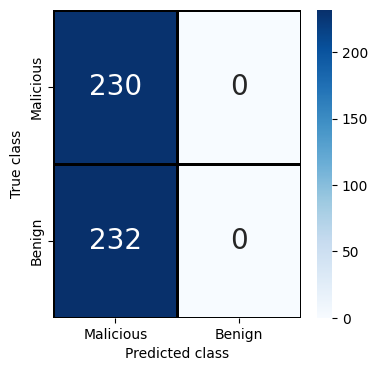

In [22]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import metrics
from utils.visualization import plot_cf_matrix

nu = 0.5421052631578948
gamma = 0.0036848421052631582

model = OneClassSVM(nu=nu, kernel="rbf", gamma = gamma)
model.fit(df_train_svm.values)

with open(f'../saved_models/pca_ocsvm/ocsvm_nu_{nu}_gamma_{gamma}.pkl', 'wb') as file:
    pickle.dump(model, file)

# change label to match oc svm
label_ocsvm = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_ocsvm'] = label_ocsvm
 
y_pred = model.predict(spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values)
y_true = spoofed_for_test.label_ocsvm

print(metrics.classification_report(y_true, y_pred, digits=5))
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
plot_cf_matrix(conf_matrix)

### Train on all traces - OCSVM


In [12]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import metrics
from utils.visualization import plot_cf_matrix

from models.ocsvm import optimize_OneClassSVM



nu_opt, gamma_opt = optimize_OneClassSVM(df_train_svm, 20)

# round to 5 decimal places

nu = round(nu_opt, 5)
gamma = round(gamma_opt, 5)

model = OneClassSVM(nu=nu, kernel="rbf", gamma = gamma)
model.fit(df_train_svm.values)

with open(f'../saved_models/pca_ocsvm/ocsvm_nu_{nu}_gamma_{gamma}.pkl', 'wb') as file:
    pickle.dump(model, file)

Searching for optimal hyperparameters...
Found: nu = 0.5421052631578948, gamma = 0.026323157894736843


In [ ]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import metrics

# Load the pickled model
with open(f'../saved_models/pca_ocsvm/ocsvm_nu_{nu}_gamma_{gamma}.pkl', 'rb') as file:
    model = pickle.load(file)

from utils.visualization import plot_cf_matrix

conf_matrix_list = []

for trace in range(1, 9):

    spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv',
                                    selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                                    trace_num=trace)

    spoofed_for_test = process_spoofed_data(spoofed_data, scaler, pca_train)

    # change label to match oc svm
    label_ocsvm = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
    spoofed_for_test['label_ocsvm'] = label_ocsvm
    
    y_pred = model.predict(spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values)
    y_true = spoofed_for_test.label_ocsvm

    print(metrics.classification_report(y_true, y_pred, digits=5))
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    conf_matrix_list.append(conf_matrix)
    
    plot_cf_matrix(conf_matrix, 
                title=f'Trace {trace} - Confusion Matrix\nnu={nu}, gamma={gamma}',
                path=f'../outputs/img/ocsvm/trace{trace}_cf_matrix_nu_{nu_opt}_gamma_{gamma_opt}.png')

## Local Outlier Factor (LOF)

### lof data preparation

In [17]:
df_train_lof = df_train[['pca-one', 'pca-two', 'pca-three']]
df_train_lof

,pca-one,pca-two,pca-three
0,0.960071,0.443752,0.732593
1,0.959436,0.444372,0.732361
2,0.958636,0.445725,0.731010
3,0.955913,0.449111,0.729489
4,0.953925,0.451199,0.727151
...,...,...,...
3273,0.773919,0.752050,0.265273
3274,0.466864,0.182363,0.368353
3275,0.927748,0.461647,0.669547
3276,0.916483,0.470821,0.666389


In [18]:
trace = 4
spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv',
                                selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                                trace_num=trace)

spoofed_for_test = process_spoofed_data(spoofed_data, scaler, pca_train)

label_lof = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_lof'] = label_lof
spoofed_for_test

,pca-one,pca-two,pca-three,label,label_lof
0,-1.231539,0.383034,1.251061,0,1
1,-1.589262,1.480378,0.889715,0,1
2,-1.339918,-0.346099,1.426732,0,1
3,-1.031668,-0.437201,1.616205,0,1
4,-1.071796,-0.259804,1.637417,0,1
...,...,...,...,...,...
457,-1.073541,-0.062071,3.373543,1,-1
458,-1.554927,-0.033699,3.186738,1,-1
459,-1.630585,0.073507,3.169712,1,-1
460,-1.519216,-0.107016,3.226708,1,-1


### train lof

In [21]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_fscore_support as score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns

from utils.visualization import plot_cf_matrix
from models.lof import optimize_LocalOutlierFactor

neighbor_opt, fscore = optimize_LocalOutlierFactor(
    df_train_lof, 
    spoofed_for_test, 
    neighbors_arange=(10,3000,100)
    )

lof = LocalOutlierFactor(n_neighbors=neighbor_opt,
                        novelty=True, # novelty detection
                        contamination=0.1, # percentage of outliers
                        n_jobs=-1, # using all processors
                        )   
lof.fit(df_train_lof.values)

y_pred = lof.predict(spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values)    
y_true = spoofed_for_test.label_lof
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    
print("Highest acheived macro average F1 was %f using %f neighbours" % (fscore, neighbor_opt))
print(metrics.classification_report(y_true, y_pred, digits=5))
print(conf_matrix)

Highest acheived macro average F1 was 0.331404 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49567   1.00000   0.66281       229
           1    0.00000   0.00000   0.00000       233

    accuracy                        0.49567       462
   macro avg    0.24784   0.50000   0.33140       462
weighted avg    0.24569   0.49567   0.32853       462

[[229   0]
 [233   0]]


/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Train on each trace

Trace {trace}: Highest acheived macro average F1 was 0.332075 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49718   1.00000   0.66415       264
           1    0.00000   0.00000   0.00000       267

    accuracy                        0.49718       531
   macro avg    0.24859   0.50000   0.33208       531
weighted avg    0.24718   0.49718   0.33020       531



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



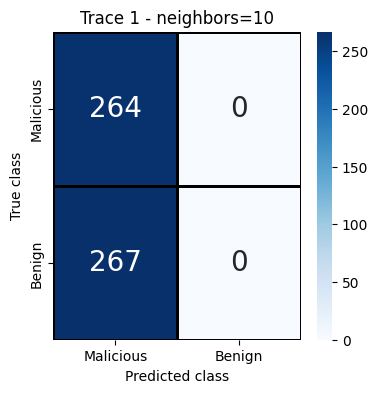

Trace {trace}: Highest acheived macro average F1 was 0.331354 using 110.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49556   1.00000   0.66271       279
           1    0.00000   0.00000   0.00000       284

    accuracy                        0.49556       563
   macro avg    0.24778   0.50000   0.33135       563
weighted avg    0.24558   0.49556   0.32841       563



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



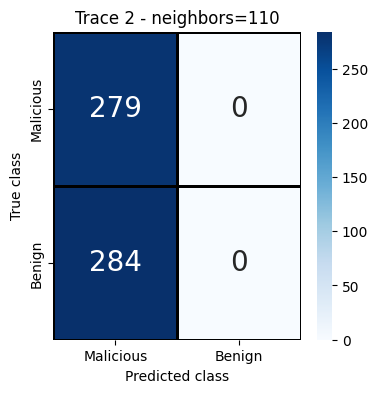

Trace {trace}: Highest acheived macro average F1 was 0.331924 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49684   1.00000   0.66385       157
           1    0.00000   0.00000   0.00000       159

    accuracy                        0.49684       316
   macro avg    0.24842   0.50000   0.33192       316
weighted avg    0.24685   0.49684   0.32982       316



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



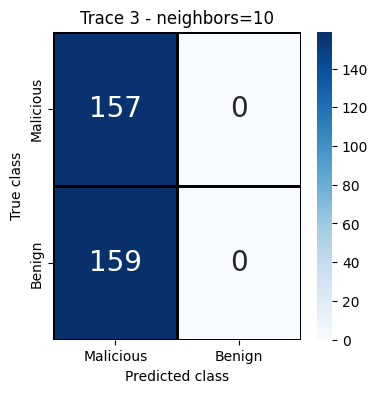

Trace {trace}: Highest acheived macro average F1 was 0.331404 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49567   1.00000   0.66281       229
           1    0.00000   0.00000   0.00000       233

    accuracy                        0.49567       462
   macro avg    0.24784   0.50000   0.33140       462
weighted avg    0.24569   0.49567   0.32853       462



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



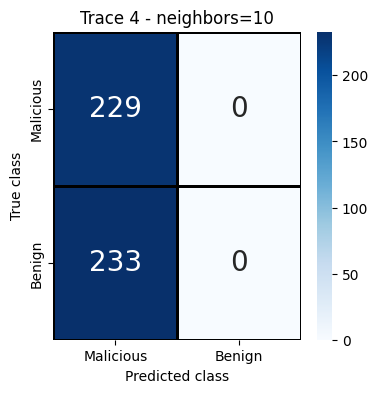

Trace {trace}: Highest acheived macro average F1 was 0.332584 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49832   1.00000   0.66517       148
           1    0.00000   0.00000   0.00000       149

    accuracy                        0.49832       297
   macro avg    0.24916   0.50000   0.33258       297
weighted avg    0.24832   0.49832   0.33146       297



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



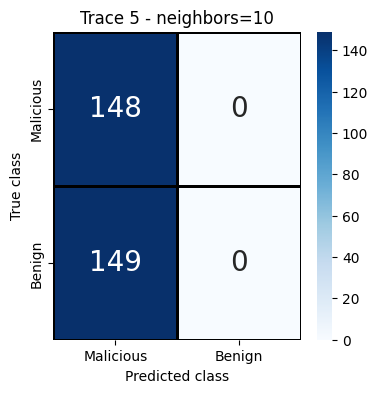

Trace {trace}: Highest acheived macro average F1 was 0.332767 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49873   1.00000   0.66553       196
           1    0.00000   0.00000   0.00000       197

    accuracy                        0.49873       393
   macro avg    0.24936   0.50000   0.33277       393
weighted avg    0.24873   0.49873   0.33192       393



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



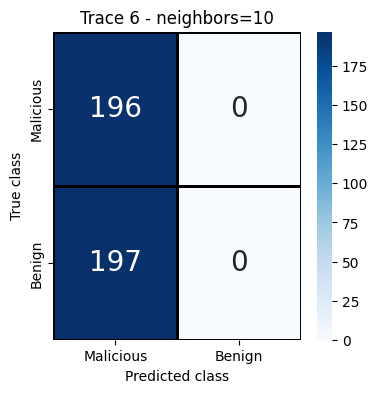

Trace {trace}: Highest acheived macro average F1 was 0.332209 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49747   1.00000   0.66442       197
           1    0.00000   0.00000   0.00000       199

    accuracy                        0.49747       396
   macro avg    0.24874   0.50000   0.33221       396
weighted avg    0.24748   0.49747   0.33053       396



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



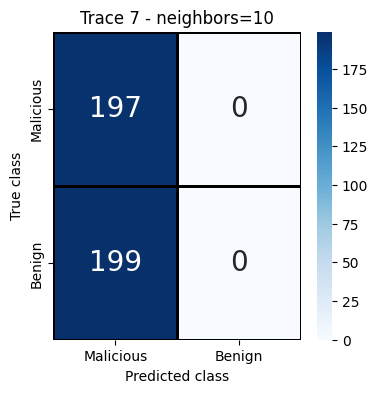

Trace {trace}: Highest acheived macro average F1 was 0.331933 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49686   1.00000   0.66387       158
           1    0.00000   0.00000   0.00000       160

    accuracy                        0.49686       318
   macro avg    0.24843   0.50000   0.33193       318
weighted avg    0.24687   0.49686   0.32985       318



/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



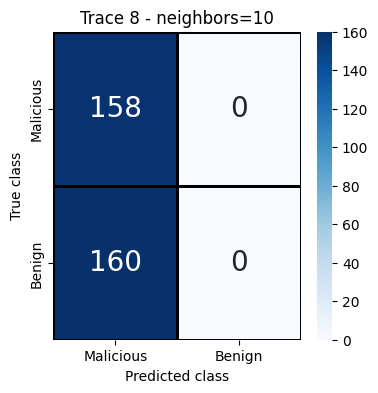

In [23]:
conf_matrix_list_lof = []

for trace in range(1, 9):

    spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv',
                                    selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                                    trace_num=trace)

    spoofed_for_test = process_spoofed_data(spoofed_data, scaler, pca_train)
    
    label_lof = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
    spoofed_for_test['label_lof'] = label_lof
    spoofed_for_test
    
    neighbor_opt, fscore = optimize_LocalOutlierFactor(
    df_train_lof, 
    spoofed_for_test, 
    neighbors_arange=(10,3000,100)
    )
    
    lof = LocalOutlierFactor(n_neighbors=neighbor_opt,
                        novelty=True, # novelty detection
                        contamination=0.1, # percentage of outliers
                        n_jobs=-1, # using all processors
                        )   
    lof.fit(df_train_lof.values)

    y_pred = lof.predict(spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values)    
    y_true = spoofed_for_test.label_lof
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    print("Trace {trace}: Highest acheived macro average F1 was %f using %f neighbours" % (fscore, neighbor_opt))
    print(metrics.classification_report(y_true, y_pred, digits=5))
    
    plot_cf_matrix(conf_matrix, 
                title=f'Trace {trace} - neighbors={neighbor_opt}',
                path=f'../outputs/img/lof/trace{trace}_cf_matrix_neighbor_{neighbor_opt}.png')

## Autoencoder

An Autoencoder Neural Network works by taking input, compressing it and trying to *reproduce the same input*. It is trained on a benign dataset using MSE. 

**Threshold**: If the MSE of the reconstructed output is over a delta threshold, 𝑇, it is classified as a novelty.
The paper did not tell us how to pick the proper threshold.

In [19]:
df_train_ae = df_train.drop(columns=['trace'])

### Autoencoder data preparation

In [20]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df_train_ae, df_train_ae, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# turn to tensor
autoencoder_X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
autoencoder_y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
autoencoder_X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
autoencoder_y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
autoencoder_X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
autoencoder_y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

# create TensorDataset
autoencoder_train_dataset = TensorDataset(autoencoder_X_train_tensor, autoencoder_y_train_tensor)
autoencoder_test_dataset = TensorDataset(autoencoder_X_test_tensor, autoencoder_y_test_tensor)
autoencoder_val_dataset = TensorDataset(autoencoder_X_val_tensor, autoencoder_y_val_tensor)

### Autoencoder Training

Monitor on wandb 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kennethwwwww. Use `wandb login --relogin` to force relogin


Epoch 1/100


100%|██████████| 72/72 [00:00<00:00, 792.38it/s]


Train Loss: 5.2696317955851555


100%|██████████| 16/16 [00:00<00:00, 3131.10it/s]


Epoch 2/100


100%|██████████| 72/72 [00:00<00:00, 1430.76it/s]


Train Loss: 2.715514442883432


100%|██████████| 16/16 [00:00<00:00, 3507.31it/s]


Epoch 3/100


100%|██████████| 72/72 [00:00<00:00, 1482.55it/s]


Train Loss: 0.8170576482079923


100%|██████████| 16/16 [00:00<00:00, 3134.76it/s]


Epoch 4/100


100%|██████████| 72/72 [00:00<00:00, 820.89it/s]


Train Loss: 0.7041099332273006


100%|██████████| 16/16 [00:00<00:00, 3612.47it/s]


Epoch 5/100


100%|██████████| 72/72 [00:00<00:00, 1612.83it/s]

Train Loss: 0.6963258781470358

100%|██████████| 16/16 [00:00<00:00, 3398.43it/s]


Epoch 6/100


100%|██████████| 72/72 [00:00<00:00, 1526.53it/s]


Train Loss: 0.6913487766869366


100%|██████████| 16/16 [00:00<00:00, 3359.14it/s]


Epoch 7/100


100%|██████████| 72/72 [00:00<00:00, 1673.49it/s]


Train Loss: 0.6828889157623053


100%|██████████| 16/16 [00:00<00:00, 3656.16it/s]


Epoch 8/100


100%|██████████| 72/72 [00:00<00:00, 1637.08it/s]


Train Loss: 0.6722896276041865


100%|██████████| 16/16 [00:00<00:00, 3690.95it/s]


Epoch 9/100


100%|██████████| 72/72 [00:00<00:00, 726.28it/s]


Train Loss: 0.656227177940309


100%|██████████| 16/16 [00:00<00:00, 2823.85it/s]


Epoch 10/100


100%|██████████| 72/72 [00:00<00:00, 1363.02it/s]


Train Loss: 0.626578891184181


100%|██████████| 16/16 [00:00<00:00, 3420.95it/s]


Epoch 11/100


100%|██████████| 72/72 [00:00<00:00, 1455.19it/s]


Train Loss: 0.5763961812481284


100%|██████████| 16/16 [00:00<00:00, 3012.07it/s]


Epoch 12/100


100%|██████████| 72/72 [00:00<00:00, 1402.33it/s]


Train Loss: 0.48145502782426775


100%|██████████| 16/16 [00:00<00:00, 3808.68it/s]


Epoch 13/100


100%|██████████| 72/72 [00:00<00:00, 1492.38it/s]


Train Loss: 0.3059670189395547


100%|██████████| 16/16 [00:00<00:00, 3238.84it/s]


Epoch 14/100


100%|██████████| 72/72 [00:00<00:00, 747.61it/s]


Train Loss: 0.24052573199151084


100%|██████████| 16/16 [00:00<00:00, 3238.22it/s]


Epoch 15/100


100%|██████████| 72/72 [00:00<00:00, 1489.24it/s]


Train Loss: 0.2294028767501004


100%|██████████| 16/16 [00:00<00:00, 2954.26it/s]


Epoch 16/100


100%|██████████| 72/72 [00:00<00:00, 1575.91it/s]


Train Loss: 0.21873787668300793


100%|██████████| 16/16 [00:00<00:00, 3574.56it/s]


Epoch 17/100


100%|██████████| 72/72 [00:00<00:00, 1609.63it/s]


Train Loss: 0.20653362869052216


100%|██████████| 16/16 [00:00<00:00, 3347.91it/s]


Epoch 18/100


100%|██████████| 72/72 [00:00<00:00, 1659.76it/s]


Train Loss: 0.19579855143092573


100%|██████████| 16/16 [00:00<00:00, 3699.29it/s]


Epoch 19/100


100%|██████████| 72/72 [00:00<00:00, 900.73it/s]


Train Loss: 0.1788713625865057


100%|██████████| 16/16 [00:00<00:00, 3711.77it/s]


Epoch 20/100


100%|██████████| 72/72 [00:00<00:00, 1632.17it/s]


Train Loss: 0.16002588253468275


100%|██████████| 16/16 [00:00<00:00, 3911.91it/s]


Epoch 21/100


100%|██████████| 72/72 [00:00<00:00, 1513.93it/s]


Train Loss: 0.13786059588892385


100%|██████████| 16/16 [00:00<00:00, 2884.91it/s]


Epoch 22/100


100%|██████████| 72/72 [00:00<00:00, 1586.96it/s]


Train Loss: 0.11787229721085168


100%|██████████| 16/16 [00:00<00:00, 3264.05it/s]


Epoch 23/100


100%|██████████| 72/72 [00:00<00:00, 1576.35it/s]


Train Loss: 0.10378424756345339


100%|██████████| 16/16 [00:00<00:00, 3768.26it/s]


Epoch 24/100


100%|██████████| 72/72 [00:00<00:00, 888.72it/s]


Train Loss: 0.09474782651523128


100%|██████████| 16/16 [00:00<00:00, 3302.44it/s]


Epoch 25/100


100%|██████████| 72/72 [00:00<00:00, 1705.52it/s]


Train Loss: 0.08935069666767959


100%|██████████| 16/16 [00:00<00:00, 3781.63it/s]


Epoch 26/100


100%|██████████| 72/72 [00:00<00:00, 1605.95it/s]


Train Loss: 0.08581135499116499


100%|██████████| 16/16 [00:00<00:00, 3547.73it/s]


Epoch 27/100


100%|██████████| 72/72 [00:00<00:00, 1479.69it/s]


Train Loss: 0.08304558545933105


100%|██████████| 16/16 [00:00<00:00, 3706.24it/s]


Epoch 28/100


100%|██████████| 72/72 [00:00<00:00, 1507.64it/s]


Train Loss: 0.08074466776452027


100%|██████████| 16/16 [00:00<00:00, 3734.91it/s]


Epoch 29/100


100%|██████████| 72/72 [00:00<00:00, 799.26it/s]


Train Loss: 0.0777561873110244


100%|██████████| 16/16 [00:00<00:00, 3517.24it/s]


Epoch 30/100


100%|██████████| 72/72 [00:00<00:00, 1527.65it/s]


Train Loss: 0.07548289088299498


100%|██████████| 16/16 [00:00<00:00, 4018.25it/s]


Epoch 31/100


100%|██████████| 72/72 [00:00<00:00, 1604.53it/s]


Train Loss: 0.07339289743686095


100%|██████████| 16/16 [00:00<00:00, 4071.15it/s]


Epoch 32/100


100%|██████████| 72/72 [00:00<00:00, 1637.48it/s]


Train Loss: 0.07073875967762433


100%|██████████| 16/16 [00:00<00:00, 3761.08it/s]


Epoch 33/100


100%|██████████| 72/72 [00:00<00:00, 1608.55it/s]


Train Loss: 0.06929172173840925


100%|██████████| 16/16 [00:00<00:00, 3489.44it/s]


Epoch 34/100


100%|██████████| 72/72 [00:00<00:00, 879.21it/s]


Train Loss: 0.06700112998078112


100%|██████████| 16/16 [00:00<00:00, 3175.10it/s]


Epoch 35/100


100%|██████████| 72/72 [00:00<00:00, 1646.92it/s]


Train Loss: 0.06664655826170929


100%|██████████| 16/16 [00:00<00:00, 3080.51it/s]


Epoch 36/100


100%|██████████| 72/72 [00:00<00:00, 1457.32it/s]


Train Loss: 0.06478963792324066


100%|██████████| 16/16 [00:00<00:00, 3314.18it/s]


Epoch 37/100


100%|██████████| 72/72 [00:00<00:00, 1580.02it/s]


Train Loss: 0.06374973934725858


100%|██████████| 16/16 [00:00<00:00, 3575.52it/s]


Epoch 38/100


100%|██████████| 72/72 [00:00<00:00, 1478.37it/s]


Train Loss: 0.06316616579715628


100%|██████████| 16/16 [00:00<00:00, 3898.50it/s]


Epoch 39/100


100%|██████████| 72/72 [00:00<00:00, 873.95it/s]


Train Loss: 0.06254724611062557


100%|██████████| 16/16 [00:00<00:00, 4012.97it/s]


Epoch 40/100


100%|██████████| 72/72 [00:00<00:00, 1490.44it/s]


Train Loss: 0.061150740744778886


100%|██████████| 16/16 [00:00<00:00, 3497.99it/s]


Epoch 41/100


100%|██████████| 72/72 [00:00<00:00, 1556.18it/s]


Train Loss: 0.06047468367614783


100%|██████████| 16/16 [00:00<00:00, 3282.73it/s]


Epoch 42/100


100%|██████████| 72/72 [00:00<00:00, 1563.58it/s]


Train Loss: 0.05964053708885331


100%|██████████| 16/16 [00:00<00:00, 3427.59it/s]


Epoch 43/100


100%|██████████| 72/72 [00:00<00:00, 1271.63it/s]


Train Loss: 0.058928841463057324


100%|██████████| 16/16 [00:00<00:00, 3610.14it/s]


Epoch 44/100


100%|██████████| 72/72 [00:00<00:00, 865.20it/s]


Train Loss: 0.058181346190394834


100%|██████████| 16/16 [00:00<00:00, 3672.17it/s]


Epoch 45/100


100%|██████████| 72/72 [00:00<00:00, 1589.97it/s]


Train Loss: 0.05697363874060102


100%|██████████| 16/16 [00:00<00:00, 3716.71it/s]


Epoch 46/100


100%|██████████| 72/72 [00:00<00:00, 1562.16it/s]


Train Loss: 0.05613907426595688


100%|██████████| 16/16 [00:00<00:00, 3513.37it/s]


Epoch 47/100


100%|██████████| 72/72 [00:00<00:00, 1609.66it/s]


Train Loss: 0.05533091170946136


100%|██████████| 16/16 [00:00<00:00, 3707.06it/s]


Epoch 48/100


100%|██████████| 72/72 [00:00<00:00, 1576.81it/s]


Train Loss: 0.053530583609244786


100%|██████████| 16/16 [00:00<00:00, 3695.02it/s]


Epoch 49/100


100%|██████████| 72/72 [00:00<00:00, 877.53it/s]


Train Loss: 0.05128566798521206


100%|██████████| 16/16 [00:00<00:00, 3442.36it/s]


Epoch 50/100


100%|██████████| 72/72 [00:00<00:00, 1414.09it/s]


Train Loss: 0.049660625896649435


100%|██████████| 16/16 [00:00<00:00, 3460.11it/s]


Epoch 51/100


100%|██████████| 72/72 [00:00<00:00, 1601.11it/s]


Train Loss: 0.048542518488829955


100%|██████████| 16/16 [00:00<00:00, 3325.68it/s]


Epoch 52/100


100%|██████████| 72/72 [00:00<00:00, 1633.07it/s]


Train Loss: 0.047408282189280726


100%|██████████| 16/16 [00:00<00:00, 3743.66it/s]


Epoch 53/100


100%|██████████| 72/72 [00:00<00:00, 1623.16it/s]


Train Loss: 0.04721058806171641


100%|██████████| 16/16 [00:00<00:00, 3275.36it/s]


Epoch 54/100


100%|██████████| 72/72 [00:00<00:00, 821.43it/s]


Train Loss: 0.04582420609949622


100%|██████████| 16/16 [00:00<00:00, 3508.96it/s]


Epoch 55/100


100%|██████████| 72/72 [00:00<00:00, 1508.52it/s]


Train Loss: 0.04419513339234982


100%|██████████| 16/16 [00:00<00:00, 3431.27it/s]


Epoch 56/100


100%|██████████| 72/72 [00:00<00:00, 1540.07it/s]


Train Loss: 0.04387325271090958


100%|██████████| 16/16 [00:00<00:00, 3805.22it/s]


Epoch 57/100


100%|██████████| 72/72 [00:00<00:00, 1541.55it/s]


Train Loss: 0.04166175848513376


100%|██████████| 16/16 [00:00<00:00, 3733.87it/s]


Epoch 58/100


100%|██████████| 72/72 [00:00<00:00, 1563.93it/s]


Train Loss: 0.03988848491280805


100%|██████████| 16/16 [00:00<00:00, 3701.13it/s]


Epoch 59/100


100%|██████████| 72/72 [00:00<00:00, 922.12it/s]


Train Loss: 0.038767238474974874


100%|██████████| 16/16 [00:00<00:00, 3469.77it/s]


Epoch 60/100


100%|██████████| 72/72 [00:00<00:00, 1309.19it/s]


Train Loss: 0.03638825578673277


100%|██████████| 16/16 [00:00<00:00, 3755.81it/s]


Epoch 61/100


100%|██████████| 72/72 [00:00<00:00, 1636.74it/s]


Train Loss: 0.03198684884409886


100%|██████████| 16/16 [00:00<00:00, 3660.55it/s]


Epoch 62/100


100%|██████████| 72/72 [00:00<00:00, 1609.22it/s]


Train Loss: 0.029109885239449795


100%|██████████| 16/16 [00:00<00:00, 3354.27it/s]


Epoch 63/100


100%|██████████| 72/72 [00:00<00:00, 1640.72it/s]


Train Loss: 0.02618122412241064


100%|██████████| 16/16 [00:00<00:00, 3598.91it/s]


Epoch 64/100


100%|██████████| 72/72 [00:00<00:00, 904.92it/s]


Train Loss: 0.022978789966145996


100%|██████████| 16/16 [00:00<00:00, 3500.36it/s]


Epoch 65/100


100%|██████████| 72/72 [00:00<00:00, 1632.51it/s]


Train Loss: 0.020562422956572846


100%|██████████| 16/16 [00:00<00:00, 3502.55it/s]


Epoch 66/100


100%|██████████| 72/72 [00:00<00:00, 1629.15it/s]


Train Loss: 0.018752276249870192


100%|██████████| 16/16 [00:00<00:00, 3757.50it/s]


Epoch 67/100


100%|██████████| 72/72 [00:00<00:00, 1559.24it/s]


Train Loss: 0.016520063665666385


100%|██████████| 16/16 [00:00<00:00, 3397.23it/s]


Epoch 68/100


100%|██████████| 72/72 [00:00<00:00, 1552.93it/s]


Train Loss: 0.014693646120576886


100%|██████████| 16/16 [00:00<00:00, 4106.78it/s]


Epoch 69/100


100%|██████████| 72/72 [00:00<00:00, 799.93it/s]


Train Loss: 0.013413018255960196


100%|██████████| 16/16 [00:00<00:00, 3454.41it/s]


Epoch 70/100


100%|██████████| 72/72 [00:00<00:00, 1477.41it/s]


Train Loss: 0.012310062986216508


100%|██████████| 16/16 [00:00<00:00, 3458.68it/s]


Epoch 71/100


100%|██████████| 72/72 [00:00<00:00, 1433.60it/s]


Train Loss: 0.011161042875755811


100%|██████████| 16/16 [00:00<00:00, 3659.75it/s]


Epoch 72/100


100%|██████████| 72/72 [00:00<00:00, 1455.20it/s]


Train Loss: 0.010360349289840087


100%|██████████| 16/16 [00:00<00:00, 3052.21it/s]


Epoch 73/100


100%|██████████| 72/72 [00:00<00:00, 1139.39it/s]


Train Loss: 0.009445628167668474


100%|██████████| 16/16 [00:00<00:00, 3822.34it/s]


Epoch 74/100


100%|██████████| 72/72 [00:00<00:00, 841.96it/s]


Train Loss: 0.00884672734355263


100%|██████████| 16/16 [00:00<00:00, 3774.40it/s]


Epoch 75/100


100%|██████████| 72/72 [00:00<00:00, 1635.82it/s]


Train Loss: 0.008366447351363604


100%|██████████| 16/16 [00:00<00:00, 3426.72it/s]


Epoch 76/100


100%|██████████| 72/72 [00:00<00:00, 1603.53it/s]


Train Loss: 0.007701899548919755


100%|██████████| 16/16 [00:00<00:00, 3784.19it/s]


Epoch 77/100


100%|██████████| 72/72 [00:00<00:00, 1582.11it/s]


Train Loss: 0.006890951297464198


100%|██████████| 16/16 [00:00<00:00, 3597.94it/s]


Epoch 78/100


100%|██████████| 72/72 [00:00<00:00, 831.39it/s]


Train Loss: 0.006278728713368764


100%|██████████| 16/16 [00:00<00:00, 2771.49it/s]


Epoch 79/100


100%|██████████| 72/72 [00:00<00:00, 165.44it/s]


Train Loss: 0.00577467753100791


100%|██████████| 16/16 [00:00<00:00, 1062.20it/s]


Epoch 80/100


100%|██████████| 72/72 [00:00<00:00, 1100.19it/s]


Train Loss: 0.005362569501812686


100%|██████████| 16/16 [00:00<00:00, 3574.75it/s]


Epoch 81/100


100%|██████████| 72/72 [00:00<00:00, 1454.16it/s]


Train Loss: 0.005116081310916343


100%|██████████| 16/16 [00:00<00:00, 2670.15it/s]


Epoch 82/100


100%|██████████| 72/72 [00:00<00:00, 1305.26it/s]


Train Loss: 0.00473429235353251


100%|██████████| 16/16 [00:00<00:00, 2933.59it/s]


Epoch 83/100


100%|██████████| 72/72 [00:00<00:00, 422.73it/s]


Train Loss: 0.004711730691269622


100%|██████████| 16/16 [00:00<00:00, 2575.17it/s]


Epoch 84/100


100%|██████████| 72/72 [00:00<00:00, 1218.40it/s]


Train Loss: 0.004305208749428857


100%|██████████| 16/16 [00:00<00:00, 1817.54it/s]


Epoch 85/100


100%|██████████| 72/72 [00:00<00:00, 1118.08it/s]


Train Loss: 0.00414315771922702


100%|██████████| 16/16 [00:00<00:00, 2987.93it/s]


Epoch 86/100


100%|██████████| 72/72 [00:00<00:00, 1158.06it/s]


Train Loss: 0.004022744367830455


100%|██████████| 16/16 [00:00<00:00, 2929.88it/s]


Epoch 87/100


100%|██████████| 72/72 [00:00<00:00, 719.58it/s]


Train Loss: 0.003920756260413327


100%|██████████| 16/16 [00:00<00:00, 2941.18it/s]


Epoch 88/100


100%|██████████| 72/72 [00:00<00:00, 1395.43it/s]


Train Loss: 0.0037188181959209032


100%|██████████| 16/16 [00:00<00:00, 3340.91it/s]


Epoch 89/100


100%|██████████| 72/72 [00:00<00:00, 1398.63it/s]


Train Loss: 0.003624848548497539


100%|██████████| 16/16 [00:00<00:00, 3480.57it/s]


Epoch 90/100


100%|██████████| 72/72 [00:00<00:00, 1539.41it/s]


Train Loss: 0.0034389235279377317


100%|██████████| 16/16 [00:00<00:00, 3081.22it/s]


Epoch 91/100


100%|██████████| 72/72 [00:00<00:00, 783.61it/s]


Train Loss: 0.003279683482105611


100%|██████████| 16/16 [00:00<00:00, 3284.02it/s]


Epoch 92/100


100%|██████████| 72/72 [00:00<00:00, 1499.47it/s]


Train Loss: 0.0033210389301530086


100%|██████████| 16/16 [00:00<00:00, 3180.36it/s]


Epoch 93/100


100%|██████████| 72/72 [00:00<00:00, 1505.79it/s]


Train Loss: 0.0031009792646727874


100%|██████████| 16/16 [00:00<00:00, 3615.78it/s]


Epoch 94/100


100%|██████████| 72/72 [00:00<00:00, 1649.48it/s]


Train Loss: 0.0031004278134787455


100%|██████████| 16/16 [00:00<00:00, 3681.43it/s]


Epoch 95/100


100%|██████████| 72/72 [00:00<00:00, 1632.90it/s]


Train Loss: 0.002979572335789271


100%|██████████| 16/16 [00:00<00:00, 2010.27it/s]


Epoch 96/100


100%|██████████| 72/72 [00:00<00:00, 1360.41it/s]


Train Loss: 0.002957660373795079


100%|██████████| 16/16 [00:00<00:00, 3579.33it/s]


Epoch 97/100


100%|██████████| 72/72 [00:00<00:00, 1515.44it/s]


Train Loss: 0.0028991952203796245


100%|██████████| 16/16 [00:00<00:00, 3495.80it/s]


Epoch 98/100


100%|██████████| 72/72 [00:00<00:00, 1571.95it/s]


Train Loss: 0.002925726671492157


100%|██████████| 16/16 [00:00<00:00, 3445.90it/s]


Epoch 99/100


100%|██████████| 72/72 [00:00<00:00, 861.18it/s]


Train Loss: 0.0028494031212176196


100%|██████████| 16/16 [00:00<00:00, 3332.61it/s]


Epoch 100/100


100%|██████████| 72/72 [00:00<00:00, 1643.23it/s]


Train Loss: 0.0027282858709440916


100%|██████████| 16/16 [00:00<00:00, 3338.42it/s]


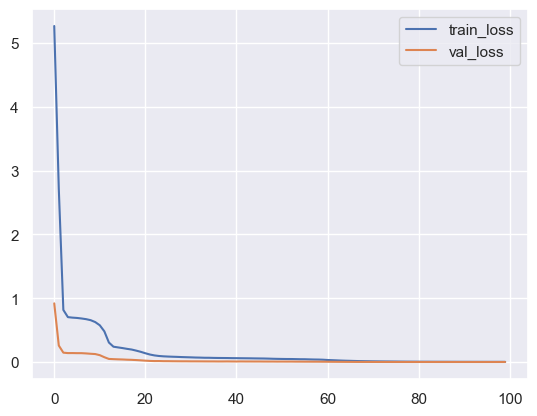

Finished Training


loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1e-05
val_loss,0.00058


(0.0027282858709440916, 0.0005838404995301971)

In [21]:
df_train, pca_train

from models.autoencoder import Autoencoder
from utils.trainer import Trainer
from sklearn.model_selection import train_test_split

FIRST_LAYER_SIZE = 25
HIDDEN_SIZE = 6
LAST_LAYER_SIZE = 25
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100

# creare Dataloader
autoencoder_train_dataloader = DataLoader(autoencoder_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder_test_dataloader = DataLoader(autoencoder_test_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder_val_dataloader = DataLoader(autoencoder_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

autoencoder_model = Autoencoder(input_size=N_COMPONENTS,
                                first_layer_size= FIRST_LAYER_SIZE,
                                hidden_size= HIDDEN_SIZE,
                                last_layer_size= LAST_LAYER_SIZE,
                                output_size= N_COMPONENTS,
                                )

autoencoder_criterion = torch.nn.MSELoss()
#adam optimizer
autoencoder_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)

autoencoder_trainer = Trainer(model=autoencoder_model, 
                              train_loader=autoencoder_train_dataloader,
                              val_loader=autoencoder_val_dataloader,
                              criterion=autoencoder_criterion,
                              optimizer=autoencoder_optimizer,
                              if_wandb=True,
                              wandb_project_name="autoencoder",)

autoencoder_trainer.train(epochs=EPOCHS)

## raytune

### autoencoder model

In [23]:

# self-defined autoencoder model

import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

N_COMPONENTS = 3

class Autoencoder(nn.Module):
    """
    Autoencoder class

    Parameters
    ----------
    nn : _type_
        _description_
    """
    
    def __init__(self, input_size=N_COMPONENTS, 
                 first_layer_size=25, 
                 hidden_size=3, 
                 last_layer_size=25, 
                 output_size=N_COMPONENTS,
                 **kwargs):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, first_layer_size),
            nn.ReLU(True),
            nn.Linear(first_layer_size, hidden_size),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, last_layer_size),
            nn.ReLU(True),
            nn.Linear(last_layer_size, output_size),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
    
def predict_spoofed(y_pred, spoofed_ae, T) -> list:
    """ 
    Predict spoofed data using the autoencoder model, over a threshold T.
    """
    
    spoofed_pred = []
    
    for y_p, s_t in zip(y_pred, spoofed_ae):
        
        mse = mean_squared_error(y_p, s_t)
        if mse > T:
            # larger than threshold, spoofed
            spoofed_pred.append(-1)
        else:
            # smaller than threshold, benign
            spoofed_pred.append(1)
            
    return spoofed_pred

### define function

In [77]:
from models import autoencoder 
import tqdm
# import Checkpoint
from ray.train import Checkpoint

def ray_trainer(config, df_train_ae):
    
    model = Autoencoder(hidden_size=config['hidden_size'])
    
    
    from torch.utils.data import TensorDataset
    from sklearn.model_selection import train_test_split

    X_train, X_temp, y_train, y_temp = train_test_split(df_train_ae, df_train_ae, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # turn to tensor
    autoencoder_X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    autoencoder_y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    autoencoder_X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    autoencoder_y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    autoencoder_X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    autoencoder_y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

    # create TensorDataset
    autoencoder_train_dataset = TensorDataset(autoencoder_X_train_tensor, autoencoder_y_train_tensor)
    autoencoder_test_dataset = TensorDataset(autoencoder_X_test_tensor, autoencoder_y_test_tensor)
    autoencoder_val_dataset = TensorDataset(autoencoder_X_val_tensor, autoencoder_y_val_tensor)
    
    train_loader = DataLoader(autoencoder_train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(autoencoder_test_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(autoencoder_val_dataset, batch_size=config['batch_size'], shuffle=True)


    criterion = torch.nn.MSELoss()
    #adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    

        
    def train_epoch():
        
        running_loss = 0.0
        
        # print progress bar using tqdm, only when epoch % 10 == 0
        
        for i, data in tqdm.tqdm(enumerate(train_loader), 
                                    total=len(train_loader),
                                    leave=True,
                                    ):
            
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # Convert to float
            inputs, labels = inputs.float(), labels.float()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            loss.backward()
            
            # Update model parameters
            optimizer.step()
            
            running_loss += loss.item()         


        print(f"Train Loss: {running_loss}")
    
        return running_loss
             
                
    def validate_epoch():
        """Execute validation process for one epoch."""
        # forward pass
        model.eval()
        
        val_loss = 0.0
        
        with torch.no_grad():
            for i, data in tqdm.tqdm(enumerate(val_loader), 
                                        total=len(val_loader),
                                        leave=True,
                                        ):
                inputs, labels = data
                inputs, labels = inputs.float(), labels.float()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()

            
        model.train()
        
        return val_loss
    
    
    train_loss = []
    val_loss = []
    
    epochs = 100
    
    for epoch in range(epochs):
        
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss.append(train_epoch())
        val_loss.append(validate_epoch())
    
    print("Finished Training")  
    
    return {"train_loss": train_loss[-1], "val_loss": val_loss[-1]}
    


### raytune train

In [78]:
from ray import tune
import ray
from functools import partial

import sys
sys.path.append('../')
# from utils.trainer import ray_trainer


trial_space = {
    # This is an example parameter. You could replace it with filesystem paths,
    # model types, or even full nested Python dicts of model configurations, etc.,
    # that enumerate the set of trials to run.
    "lr": tune.grid_search([0.001, 0.01, 0.1]),
    "batch_size": tune.grid_search([32, 64]),
    "hidden_size": tune.grid_search([3, 6]),
}

train_function = partial(ray_trainer, df_train_ae=df_train_ae)

train_model = tune.with_resources(train_function, {"cpu": 1})

from ray.train import RunConfig

tuner = tune.Tuner(train_function, param_space=trial_space, 
                   )
result_grid = tuner.fit()

2024-06-18 01:05:12,174	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/keniwo/ray_results/ray_trainer_2024-06-18_01-04-55' in 0.0083s.
2024-06-18 01:05:12,177	INFO tune.py:1041 -- Total run time: 16.21 seconds (16.19 seconds for the tuning loop).


In [79]:
best_result = result_grid.get_best_result(metric="val_loss", mode="min", scope="last")
best_checkpoint = best_result.checkpoint 
df_results = result_grid.get_dataframe() 

In [81]:
best_result.config


{'lr': 0.001, 'batch_size': 32, 'hidden_size': 6}

### Tests

In [87]:
#save model
autoencoder_trainer.save_model(path = f'../saved_models/pca_autoencoder/autoencoder_{HIDDEN_SIZE}_{LEARNING_RATE}_{BATCH_SIZE}.pth')

In [22]:
# test model on autoencoder_test_dataloader

autoencoder_trainer.model.eval()

losses = []

for i, (x, y) in enumerate(autoencoder_test_dataloader):
    y_pred = autoencoder_trainer.model(x)
    loss = autoencoder_trainer.criterion(y_pred, y)
    losses.append(loss.item())
    
print(f"Average loss on test set: {np.mean(losses)}")

Average loss on test set: 3.833884147752542e-05


### Use Autoencoder to detect spoofing by a Threshold $T$

In [25]:
# spoofing threshold

def max_element_index(lst):
    if not lst:  # Check if the list is empty
        return None, None

    max_value = lst[0]  # Initialize max_value with the first element
    max_index = 0  # Initialize max_index with the index of the first element

    for i, value in enumerate(lst):
        if value > max_value:
            max_value = value
            max_index = i

    return max_value, max_index

### time the model execution

In [37]:
# time the model execution
import time
from models.autoencoder import predict_spoofed

trace = 4
spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv',
                                    selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                                    trace_num=trace)
spoofed_for_test = process_spoofed_data(spoofed_data, scaler, pca_train)
label_ae = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1) # benign = 1, spoofed = -1
spoofed_for_test['label_ocsvm'] = label_ae

spoofed_ae = spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values

autoencoder_trainer.model.eval()

start = time.time()

y_pred = autoencoder_trainer.model(torch.tensor(spoofed_ae, dtype=torch.float32)).detach().numpy()
spoofed_pred = predict_spoofed(y_pred, spoofed_ae, T=1.11)

end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 0.03724098205566406 seconds


In [44]:
# FP rate

# benign = 1, spoofed = -1

# false_positive = benign classified as spoofed, pred = -1, true = 1
# true_negative = benign classified as benign, pred = 1, true = 1

# fp_rate = spoofed_pred.count(-1) / len(spoofed_pred)

fp = 0
tn = 0
for i,e in enumerate(spoofed_pred):
    if spoofed_pred[i] == -1:
        if y_true[i] == 1:
            fp += 1
    
    if spoofed_pred[i] == 1:
        if spoofed_for_test.label_ocsvm[i] == 1:
            tn += 1

rate = fp / (fp + tn)
rate

0.3469387755102041

In [40]:
spoofed_pred.count(1)

188

Search for a ideal T

In [33]:
from sklearn.metrics import mean_squared_error
from models.autoencoder import predict_spoofed
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns


f1_all_traces = []
prec_all_traces = []
rec_all_traces = []

for trace in range(1, 9):
    
    spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv',
                                    selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                                    trace_num=trace)

    spoofed_for_test = process_spoofed_data(spoofed_data, scaler, pca_train)

    label_ae = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
    spoofed_for_test['label_ocsvm'] = label_ae
    
    spoofed_ae = spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values
    
    autoencoder_trainer.model.eval()
    
    y_pred = autoencoder_trainer.model(torch.tensor(spoofed_ae, dtype=torch.float32)).detach().numpy()

    f1_list = []
    prec_list = []
    rec_list = []
    
    cf_matrix_list = []
    T_range = np.linspace(0.1, 20, 100)
    max_f1 = 0

    for T in T_range:
        spoofed_pred = predict_spoofed(y_pred, spoofed_ae, T)
        y_true = spoofed_for_test.label_ocsvm
        
        metrics.confusion_matrix(y_true, spoofed_pred)
        cf_matrix_list.append(
            metrics.confusion_matrix(y_true, spoofed_pred)
            )
        
        prec, rec, f1_score_ae, _ = score(y_true, spoofed_pred, average='macro', zero_division=1)
        
        print(metrics.confusion_matrix(y_true, spoofed_pred))
        
        f1_list.append(f1_score_ae)
        prec_list.append(prec)
        rec_list.append(rec)

    f1_all_traces.append(f1_list)
    max_f1, max_f1_index = max_element_index(f1_list)
    max_prec = prec_list[max_f1_index]
    max_rec = rec_list[max_f1_index]
    
    prec_all_traces.append(max_prec)
    rec_all_traces.append(max_rec)
    
    sns.set_theme(context='notebook', style='darkgrid')
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(T_range, f1_list)

    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs Threshold, with max F1 score of {max_f1} at T = { round(T_range[max_f1_index], 2) })')
    plt.savefig(f'../outputs/img/ae_threshold/trace{trace}_f1.png')
    
# average f1 score on all traces

f1_avg_list = []

for i in range(len(T_range)):
    f1_sum = 0
    for f1_list in f1_all_traces:
        f1_sum += f1_list[i]
    f1_avg = f1_sum / len(f1_all_traces)
    f1_avg_list.append(f1_avg)
    
fig = plt.figure(figsize=(6, 4))
plt.plot(T_range, f1_avg_list)


max_f1, max_f1_index = max_element_index(f1_avg_list)
plt.title(f'Average F1 Score vs Threshold, with max F1 score of {max_f1} at T = {round(T_range[np.argmax(f1_list)], 2) })')
plt.savefig(f'../outputs/img/ae_threshold/avg_trace_f1.png')
    


[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]
 [ 10 257]]
[[  0 264]


KeyboardInterrupt: 

In [29]:
sum(prec_all_traces) / len(prec_all_traces), sum(rec_all_traces) / len(rec_all_traces)

(0.6428397796917695, 0.6050177494017173)